In [95]:
import pandas as pd
import importlib
from BuildTsModel import (
    evaluate_forecast, residcheck, calculate_pi_difference
)
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
# set plot style to ggplot2
plt.style.use('ggplot')
# maximize the size of the labels, ticks, and figures
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
# legend settings
plt.rcParams['legend.fontsize'] = 10

In [96]:
# import the training and testing data
train = pd.read_csv('train.csv', index_col=0, parse_dates=True)
train = train.squeeze()
train.index.freq = 'MS'
test = pd.read_csv('test.csv', index_col=0, parse_dates=True)
test = test.squeeze()
test.index.freq = 'MS'

# SARIMA (Seasonal, Auto-Regressive, Integrated, Moving Average Model)

In [97]:
train_trend_diff = train.diff(1).dropna()
train_seasoanl_diff = train_trend_diff.diff(12)
train_seasoanl_diff.dropna(inplace=True)

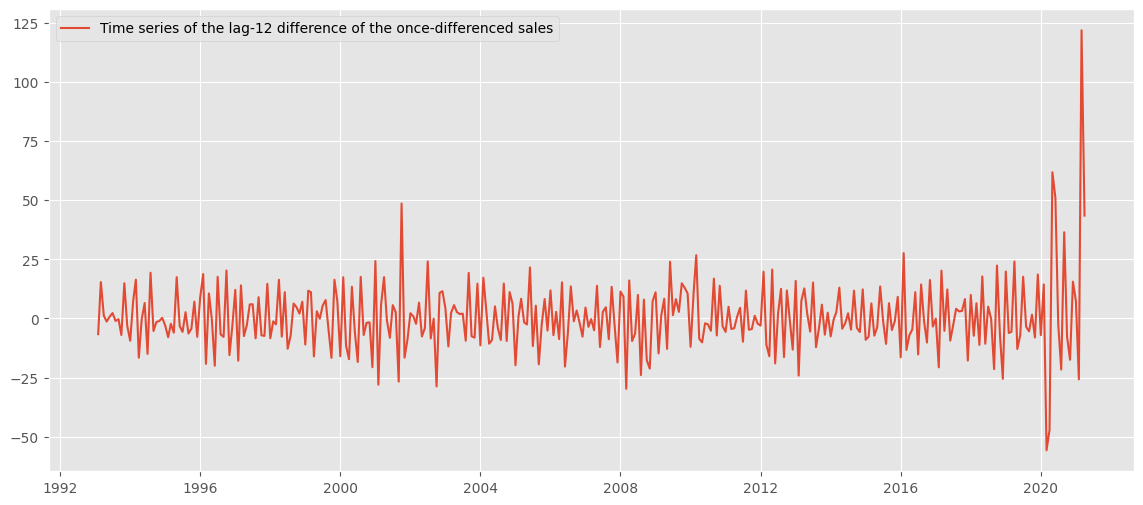

In [98]:
plt.plot(train_seasoanl_diff, label='Time series of the lag-12 difference of the once-differenced sales')
plt.legend()
plt.show()

In [99]:
#Check for stationarity
result = sm.tsa.stattools.adfuller(train_seasoanl_diff, autolag= 'AIC')
if result[1] < 0.05:
    print('Time series is stationary')
else:
    print('Time series is not stationary')

Time series is stationary


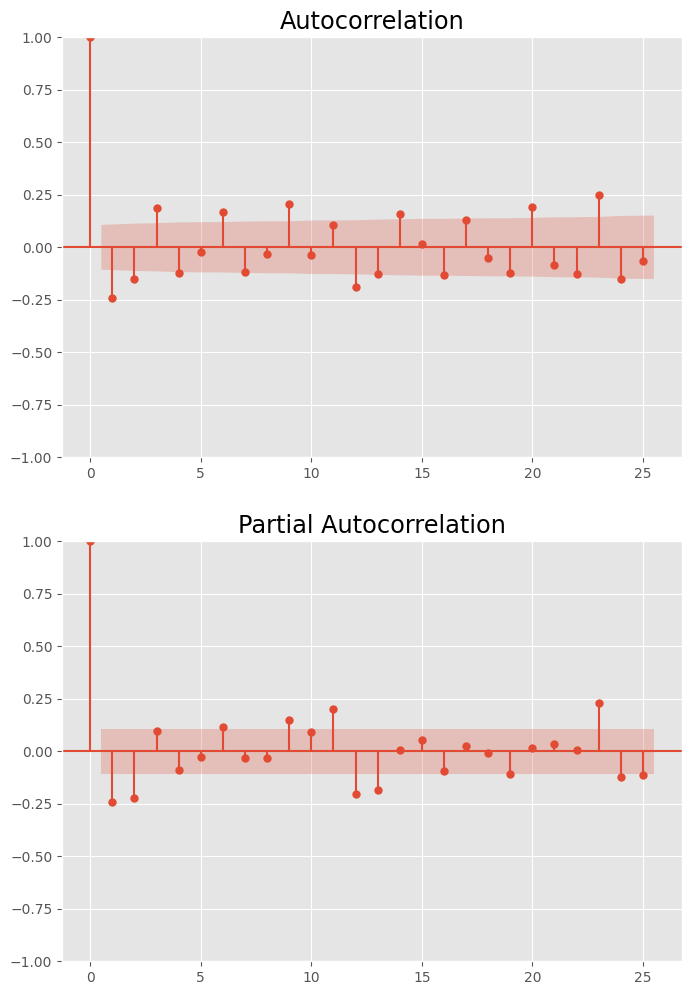

In [100]:
fig, ax = plt.subplots(2, figsize=(8,12))
sm.graphics.tsa.plot_acf(train_seasoanl_diff , lags=25, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_seasoanl_diff , lags=25, ax=ax[1])
plt.show()

In [101]:
# Fit the model using auto_arima
model = pm.auto_arima(train, 
                      test='adf',       # use the ADF test to find best order of integration
                      max_p=3, max_q=3, # maximum p and q
                      m=12,             # frequency of series (12 for monthly data)
                      seasonal=True,    # allow for seasonality
                      start_P=0,        # starting value of seasonal order
                      trace=True,       # print diagnostic information
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,    # use a stepwise algorithm to speed up fitting
                      information_criterion='aic', # Select based on AIC
                      enforce_stationarity=False,  # don't enforce stationarity
                      enforce_invertibility=False  # don't enforce invertibility
                     )

# Print the model summary
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=3256.918, Time=2.63 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3721.224, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3266.648, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3719.368, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=3482.411, Time=1.18 sec
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.80 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=3114.106, Time=9.05 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=8.11 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=3123.364, Time=7.90 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=3119.875, Time=5.76 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=6.50 sec
 ARIMA(2,1,3)(0,0,2)[12] intercept   : AIC=3112.433, Time=8.38 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=inf, Time=4.52 sec
 ARIMA(2,1,3)(1,0,2)[12] intercept   : AIC=i

In [102]:
# models hyperparameters
p, d, q = 0, 1, 2
P, D, Q, m = 0, 1, 1, 12
model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m),
                                  enforce_stationarity=False,
                                enforce_invertibility=False)
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         sales_amount   No. Observations:                  352
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1268.040
Date:                              Sat, 27 May 2023   AIC                           2544.079
Time:                                      07:57:14   BIC                           2559.202
Sample:                                  01-01-1992   HQIC                          2550.116
                                       - 04-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4512      0.027    -16.752      0.000      -0.504      -0.398
ma.L2         -0.08

# SARIMAX diagnostic tests

** Mean of the residuals:  0.47

** Ljung Box Test, p-value: 0.49 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<Axes: >,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

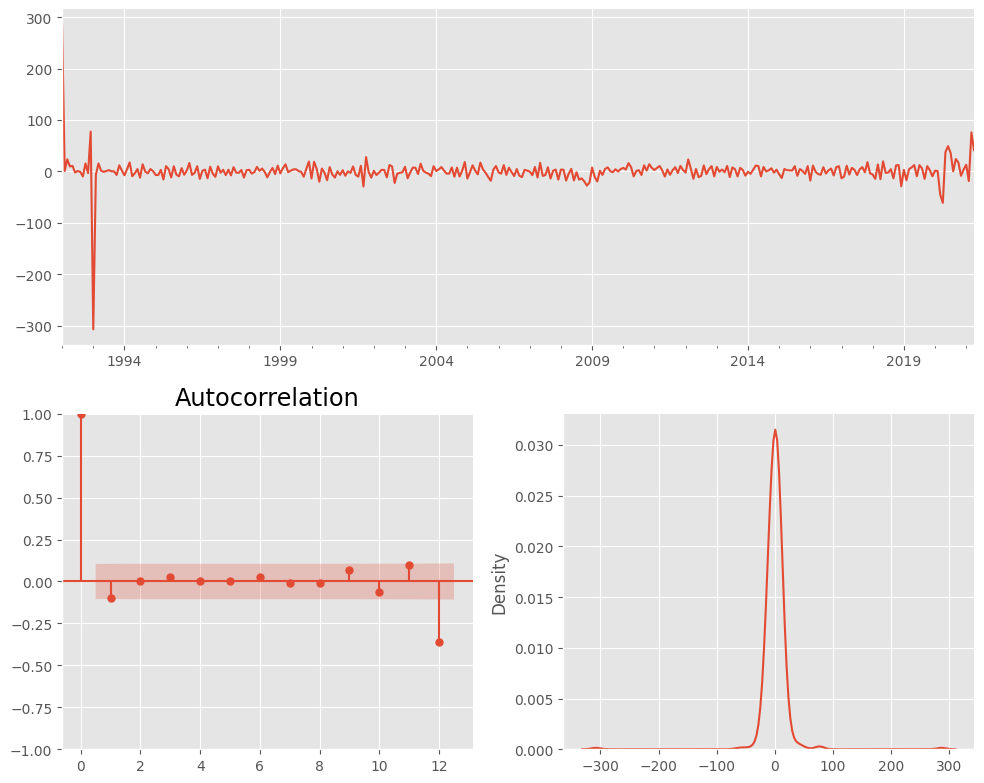

In [103]:
residcheck(results.resid, 12)

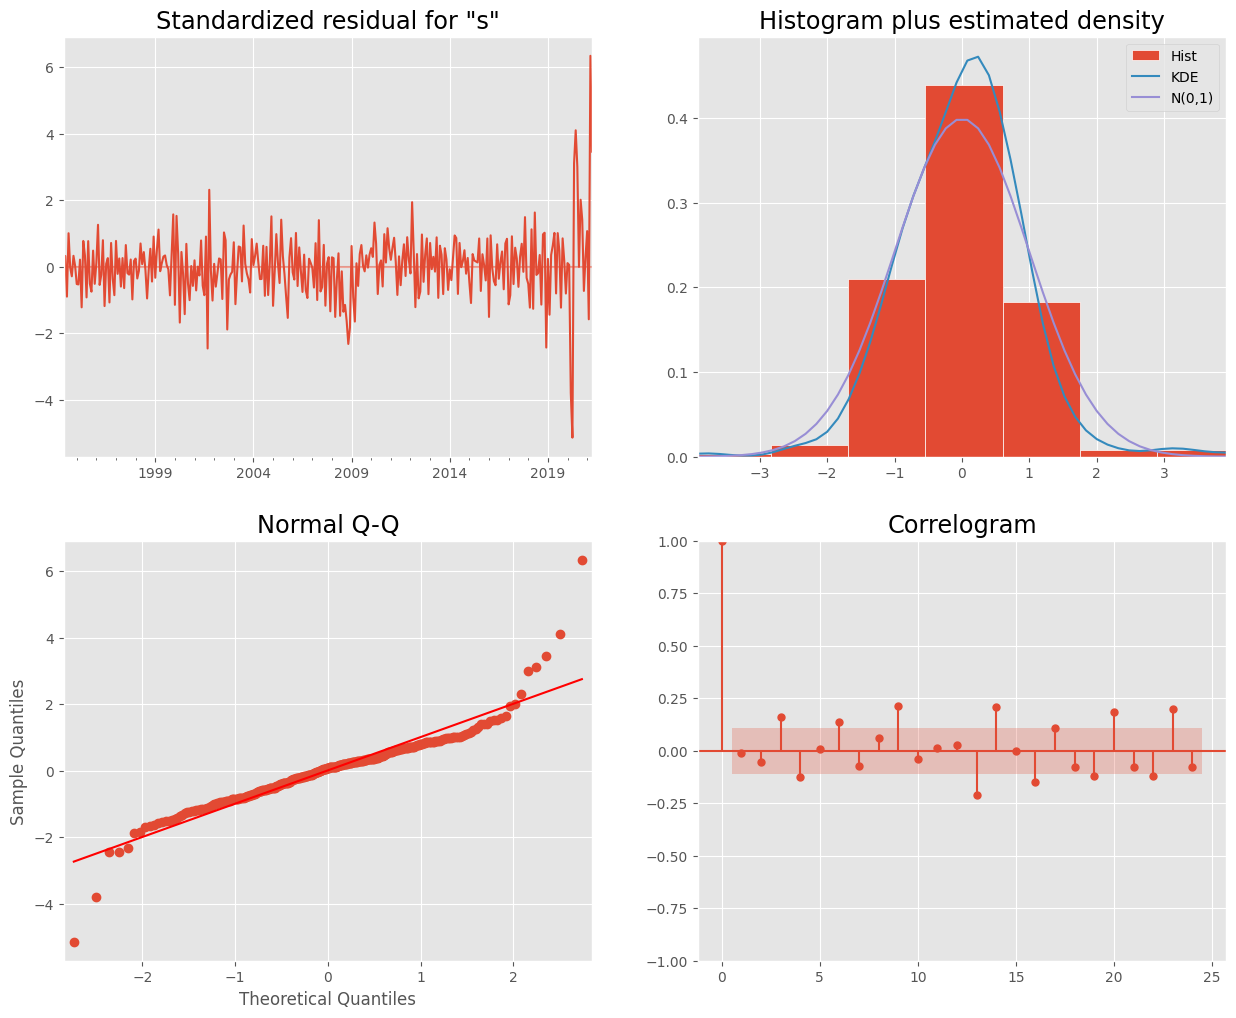

In [104]:
# Perform diagnostic tests on the residuals
results.plot_diagnostics(figsize=(15, 12), lags=24)
plt.show()

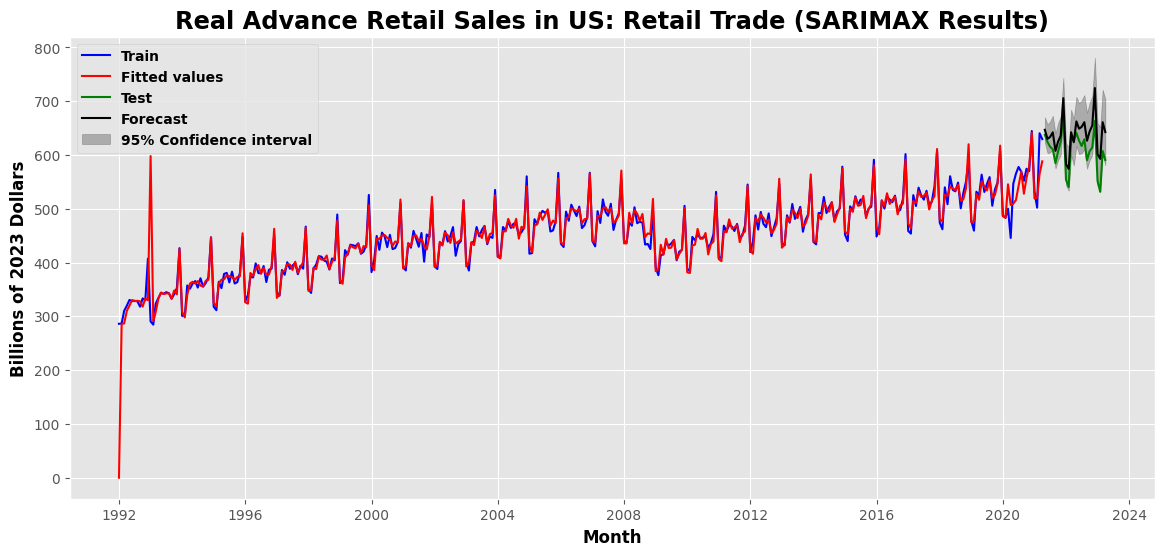

In [105]:
# Get the forecast
forecast = results.get_forecast(steps=len(test))

# Get the confidence intervals
forecast_ci = forecast.conf_int(0.95)

# Plot the forecast and the confidence intervals
fig, ax = plt.subplots()
ax.plot(train.index, train, label='Train', color='blue')
ax.plot(results.fittedvalues.index, results.fittedvalues, label='Fitted values', color='red')
ax.plot(test.index, test, label='Test', color='green')
ax.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='black')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.25, label='95% Confidence interval')

# Set the axis labels and legend
plt.title("Real Advance Retail Sales in US: Retail Trade (SARIMAX Results)", color='black', weight='bold')
ax.set_xlabel('Month', color='black', weight='bold')
ax.set_ylabel('Billions of 2023 Dollars', color='black', weight='bold')
# bold the legend font
legend = ax.legend(loc='upper left')
for label in legend.get_texts():
    label.set_fontweight('bold')
plt.show()



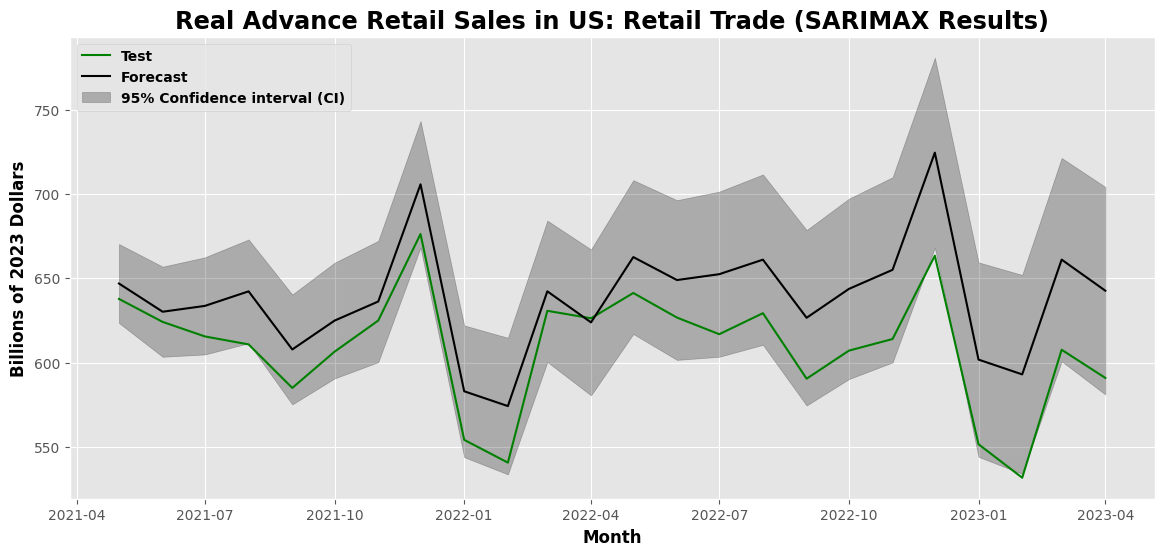

In [106]:
# Plot the forecast and the confidence intervals
fig, ax = plt.subplots()
ax.plot(test.index, test, label='Test', color='green')
ax.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='black')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.25, label='95% Confidence interval (CI)')

# Set the axis labels and legend
plt.title("Real Advance Retail Sales in US: Retail Trade (SARIMAX Results)", color='black', weight='bold')
ax.set_xlabel('Month', color='black', weight='bold')
ax.set_ylabel('Billions of 2023 Dollars', color='black', weight='bold')
# bold the legend font
legend = ax.legend(loc='upper left')
for label in legend.get_texts():
    label.set_fontweight('bold')
plt.show()



In [107]:
evaluate_forecast('SARIMAX', test, forecast.predicted_mean)

{'Model': 'SARIMAX', 'MAE': 30.2595, 'RMSE': 34.4833, 'MAPE': 5.0523}

In [108]:
# check the coverage of the predicted intervals for testing set
calculate_pi_difference(test, forecast_ci)

{'coverage': 0.875,
 'coverage_description': 'The proportion of true values within the confidence interval.',
 'ci_width': 2127.523,
 'ci_width_description': 'The width of the confidence interval, which indicates the uncertainty of the forecast.'}